In [23]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
train = pd.read_csv('./output/train.csv')    
test = pd.read_csv('./output/test.csv')    
test2 = pd.read_csv('./output/test2.csv')

def within_measure(x, y):
    #  3750901.5068 ≤ 𝑥 ≤ 3770901.5068
    #  −19268905.6133 ≤ 𝑦 ≤ −19208905.6133
    if 3750901.5068 <= x and x <= 3770901.5068 and -19268905.6133 <= y and y <= -19208905.6133:
        return 1
    else:
        return 0

train = train.append(test[test.x_exit==test.x_exit])
cols=['hash','trajectory_id','x_exit','y_exit',
      #'distance_to_city'
     ]   
x_train = train[['x_entry','y_entry']]
x_test = test2[['x_entry','y_entry']]



y_train=pd.DataFrame()

y_train['x_exit']=train['x_exit']
y_train['y_exit']=train['y_exit']

In [3]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983684 entries, 0 to 202935
Data columns (total 2 columns):
x_exit    983684 non-null float64
y_exit    983684 non-null float64
dtypes: float64(2)
memory usage: 22.5 MB


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983684 entries, 0 to 202935
Data columns (total 28 columns):
hash                983684 non-null object
trajectory_id       983684 non-null object
time_entry          983684 non-null int64
time_exit           983684 non-null int64
vmax                983684 non-null float64
vmin                983684 non-null float64
vmean               983684 non-null float64
x_entry             983684 non-null float64
y_entry             983684 non-null float64
x_exit              983684 non-null float64
y_exit              983684 non-null float64
first               983684 non-null bool
last                983684 non-null bool
x_req               983684 non-null float64
y_req               983684 non-null float64
x_start             983684 non-null float64
y_start             983684 non-null float64
distance            983684 non-null float64
time_start          983684 non-null int64
time_delta          983684 non-null int64
time_total          98368

In [5]:
from keras.models import Sequential

model = Sequential()
from keras.layers import Dense

model.add(Dense(units=1000, activation='relu', input_dim=np.shape(x_train)[1]))
model.add(Dense(units=1000, activation='relu'))
model.add(Dense(units=1000, activation='relu'))

model.add(Dense(units=2, activation='softmax'))

from keras import optimizers

sgd = optimizers.SGD(lr=0.1, clipnorm=1.)

model.compile(loss='mean_squared_error',
              optimizer=sgd,
              metrics=['mean_absolute_error'],
             )


devide_clusters = False

def naklastry():
    pred = pd.DataFrame({'c':test2_c,'target':test2_c})

    for c in labels:
        xc_train=x_train[train_c==c]
        yc_train=y_train[train_c==c][unnown].values
        xc_test=x_test[test2_c==c]
        if len(xc_test)==0:
            continue
        print(len(xc_train),len(xc_test))
        d_train = lgb.Dataset(xc_train, label=yc_train)
        clf = lgb.train(params, d_train)
        
        #Prediction
        def add(row,c):
            if row['c']==c:
                return target.pop(0)
            else:
                return row.target
            
        target=list(clf.predict(xc_test))
        pred['target'] = pred.apply(lambda x: add(x,c), axis=1)
                 
        print('done:',c)
    return pred.target.values

def jedna(t = False):
    # batch_size=500
    model.fit(x_train, y_train.values,batch_size=5000, epochs=10,verbose=True)
    
    #Prediction    
    target=list(model.predict(x_test))
    
    #print('Train Evaluation:',model.evaluate(x_train, y_train.values))
    if t==True:
        target2=list(model.predict(x_train))
        return target, target2

    return target
  
        
city_lgbm_c=pd.DataFrame()
city_lgbm=pd.DataFrame()

if devide_clusters:
    result = naklastry()
    result = np.array(result)
    city_lgbm_c['x_exit']=result[:,0]
    city_lgbm_c['y_exit']=result[:,1]
    
result = jedna(t=False)   
result = np.array(result)
city_lgbm['x_exit']=result[:,0]
city_lgbm['y_exit']=result[:,1]

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
983684/983684 [==============================] - 71s 73us/step - loss: 191812512322400.7500 - mean_absolute_error: 11491122.0873
Epoch 2/10
983684/983684 [==============================] - 73s 74us/step - loss: 191812511704514.3438 - mean_absolute_error: 11491122.0645
Epoch 3/10
983684/983684 [==============================] - 74s 75us/step - loss: 191812510491118.3125 - mean_absolute_error: 11491122.0623
Epoch 4/10
983684/983684 [==============================] - 72s 73us/step - loss: 191812512216929.5938 - mean_absolute_error: 11491122.0836
Epoch 5/10
983684/983684 [==============================] - 73s 75us/step - loss: 191812510523387.2812 - mean_absolute_error: 11491122.1545
Epoch 6/10
983684/983684 [==============================] - 72s 74us/step - loss: 191812508717619.8750 - mean_absolute_error: 11491122.0923
Epoch 7/10
983684/983684 [==============

In [6]:
import statistics
X = test2['x_entry'].values 
Y = test2['y_entry'].values

def score(x):
    if x>=0.5:
        return 1
    else:
        return 0



city_lgbm['target'] = [within_measure(x, y) for x,y in zip(city_lgbm.x_exit.values,city_lgbm.y_exit.values)]



In [20]:



#city = [score(statistics.mean(k)) for k in zip(city_lgbm_c.target.values,city_lgbm.target.values)]

city_sqrt = [within_measure(x, y) for x,y in zip(test2.x_entry.values,test2.y_entry.values)]

submission= pd.DataFrame()
trajectory_id = test2['trajectory_id']
submission['id']=trajectory_id 
submission['target'] = city_lgbm.target
submission.to_csv('./output/nn/lgbm.csv',index=False)    



In [25]:
def plotmap(ycity,title):
    fig, ax = plt.subplots()
    fig.set_figheight(10)
    fig.set_figwidth(16)

    df=test2[['x_entry','y_entry']]
    df['sqrt']=city_sqrt
    df['target']=ycity
    #df=df[df.sqrt==0]
    leg=['Outside','City']
    # Plot
    for data in [df[df.target==1]]:
        ax.scatter(data.x_entry.values, data.y_entry.values,c='r',s=10, alpha=0.5,label=leg.pop(0))

    # Create a Rectangle patch
    rect = patches.Rectangle((3750901.5068,-19268905.6133),3770901.5068-3750901.5068,19268905.6133-19208905.6133,linewidth=2,edgecolor='y',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)    

    ax.set(xlabel='x', ylabel='y',
           title=title)
    ax.legend(loc="upper left", markerscale=2, scatterpoints=1, fontsize=10)
    plt.show()

C:\Users\J.K. Pawłowski\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\J.K. Pawłowski\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


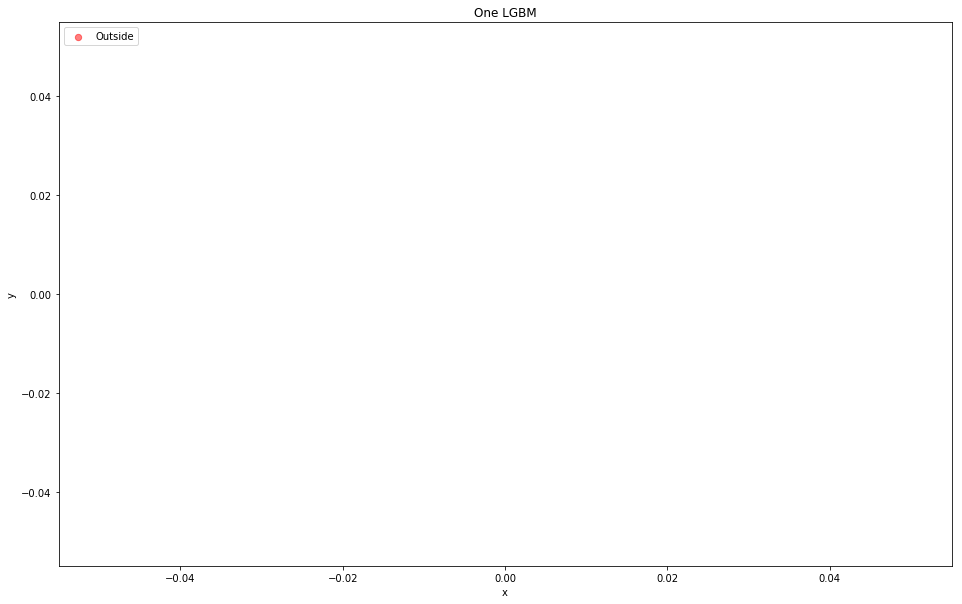

In [26]:
plotmap(city_lgbm.target.values,'One LGBM')

In [16]:
if devide_clusters:
    plotmap(city_lgbm_c.target.values,'Clusters LGBM')

In [19]:
if devide_clusters:
    plotmap(city.target.values,'Submission outside the sqrt')